# Main figure 2

- Panel A: Histogram of total single-cells used in model across genotypes
- Panel B: UMAP of all plates used in model labelling genotype
- Panel C: Well aggregated pairwise comparisons with all plates

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(patchwork))
suppressPackageStartupMessages(library(arrow))
suppressPackageStartupMessages(library(RColorBrewer))

Warning message:
“package ‘dplyr’ was built under R version 4.2.3”


Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”
Warning message:
“package ‘patchwork’ was built under R version 4.2.3”
Warning message:
“package ‘arrow’ was built under R version 4.2.3”
Warning message:
“package ‘RColorBrewer’ was built under R version 4.2.3”


In [2]:
figure_dir <- "../figures"
output_main_figure_2 <- file.path(
    figure_dir, "main_figure_2_UMAP_sc_correlations.png"
)

## UMAP

In [3]:
# Path to UMAP results
UMAP_results_dir <- file.path(
    "/media/18tbdrive/1.Github_Repositories/nf1_schwann_cell_painting_data/4.analyze_data/notebooks/UMAP/results/qc_profiles_results"
)

# Load data
UMAP_results_file <- file.path(UMAP_results_dir, "UMAP_concat_model_plates_sc_feature_selected_qc.tsv")

UMAP_results_df <- readr::read_tsv(UMAP_results_file)

# Update the Metadata_genotype column
UMAP_results_df <- UMAP_results_df %>%
  dplyr::mutate(Metadata_genotype = dplyr::recode(Metadata_genotype, 
                                                  Null = "Null C04", 
                                                  WT = "WT A3"))

dim(UMAP_results_df)
head(UMAP_results_df)

Rows: 20680 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): Metadata_Plate, Metadata_Well, Metadata_genotype
dbl (4): Metadata_Site, Metadata_number_of_singlecells, UMAP0, UMAP1

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] 20680     7

Metadata_Plate,Metadata_Site,Metadata_Well,Metadata_genotype,Metadata_number_of_singlecells,UMAP0,UMAP1
<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
Plate_3_prime,24,C12,Null C04,321,-1.1001104,1.931942500
Plate_3,11,C3,WT A3,344,2.0006065,-0.470333580
Plate_3,17,E12,Null C04,607,3.2071100,0.009237763
Plate_5,14,C12,Null C04,119,0.8039362,-2.132193800
Plate_3,7,G4,WT A3,386,-1.3410959,2.047840400
Plate_3,15,D4,WT A3,636,2.6869693,2.920993800


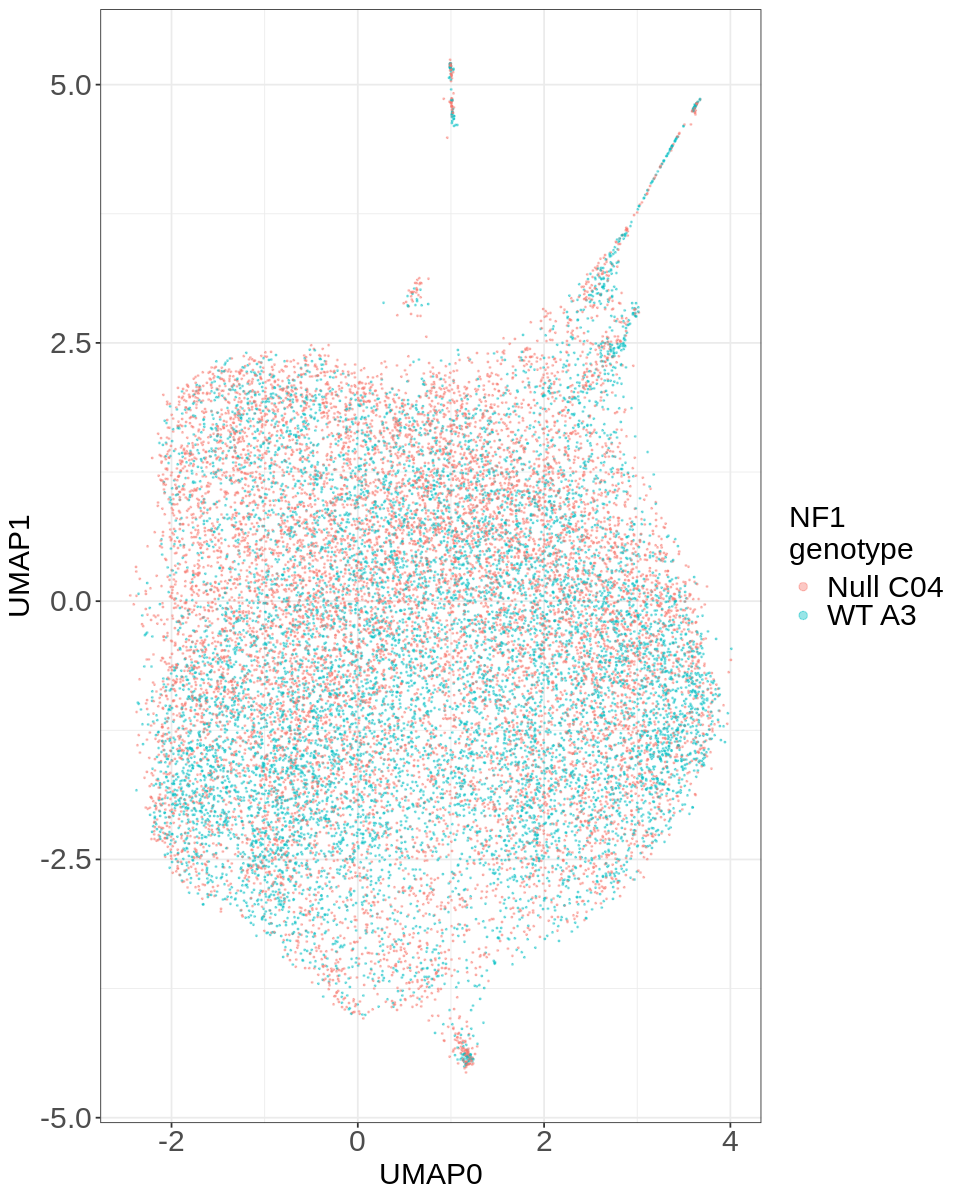

In [4]:
width <- 8
height <- 10
options(repr.plot.width = width, repr.plot.height = height)

umap_fig_gg <- (
  ggplot(UMAP_results_df, aes(x = UMAP0, y = UMAP1))
  + geom_point(
      aes(color = Metadata_genotype),
      size = 0.2,
      alpha = 0.4
  )
  + theme_bw()
  + guides(
      color = guide_legend(
          override.aes = list(size = 2)
      )
  )
  + labs(x = "UMAP0", y = "UMAP1", color = "NF1\ngenotype")
  # change the text size
  + theme(
      strip.text = element_text(size = 18),
      # x and y axis text size
      axis.text.x = element_text(size = 18),
      axis.text.y = element_text(size = 18),
      # x and y axis title size
      axis.title.x = element_text(size = 18),
      axis.title.y = element_text(size = 18),
      # legend text size
      legend.text = element_text(size = 18),
      legend.title = element_text(size = 18)
  )
)

umap_fig_gg

## Histogram

In [5]:
# Replace missing values in Metadata_genotype with "Null"
UMAP_results_df$Metadata_genotype <- na_if(UMAP_results_df$Metadata_genotype, "")

# Group by Metadata_genotype and summarize the count of rows per group across all plates
total_counts_per_genotype <- UMAP_results_df %>%
    group_by(Metadata_genotype) %>%
    summarize(count = n(), .groups = 'drop') %>%
    mutate(Metadata_Plate = "All plates")

# Confirm any NA values are "Null" strings in Metadata_genotype column
total_counts_per_genotype$Metadata_genotype[is.na(total_counts_per_genotype$Metadata_genotype)] <- "Null"

# View the resulting counts dataframe
dim(total_counts_per_genotype)
total_counts_per_genotype


[1] 2 3

Metadata_genotype,count,Metadata_Plate
<chr>,<int>,<chr>
Null C04,10900,All plates
WT A3,9780,All plates


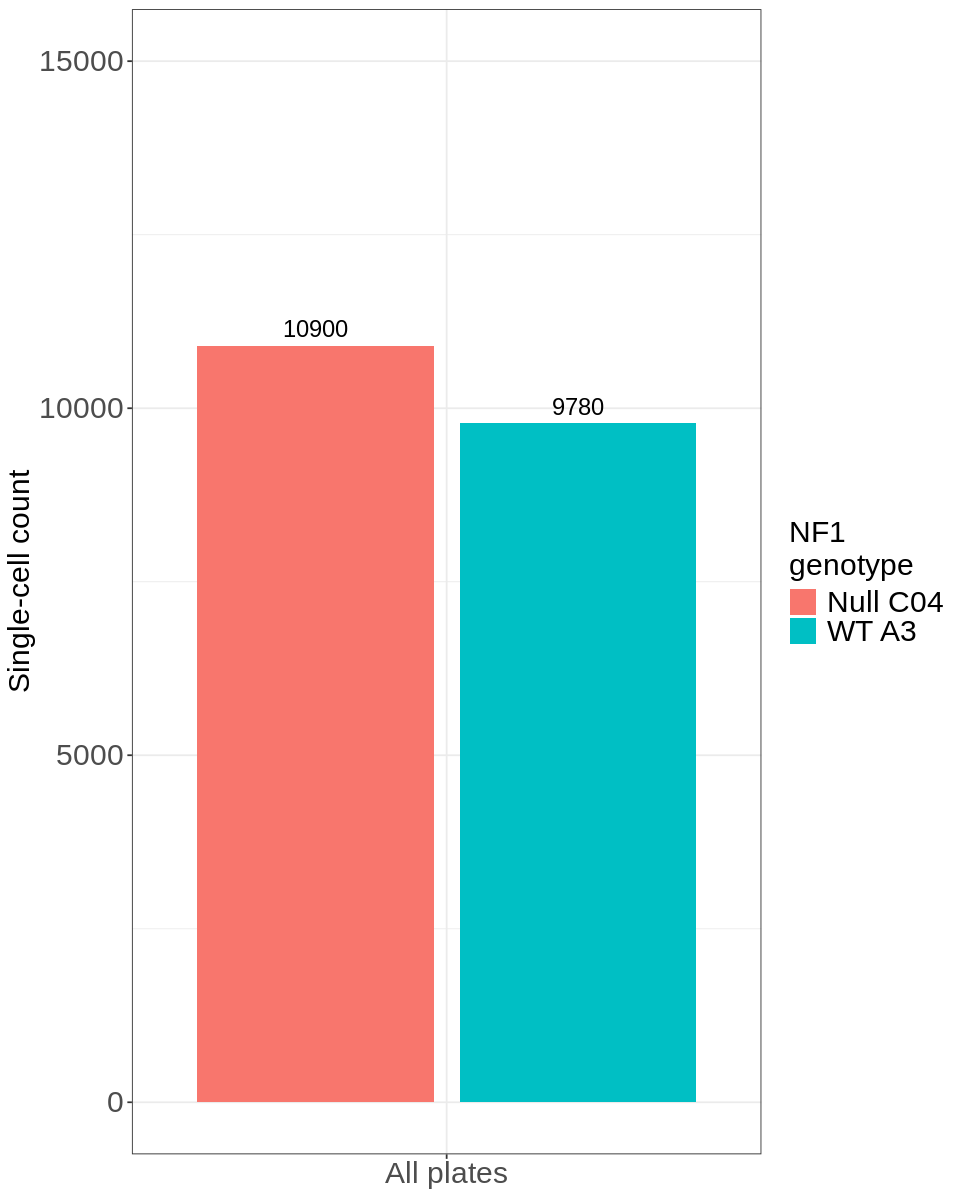

In [6]:
# Create the histogram plot with adjusted dodge width
histogram_plot <- ggplot(total_counts_per_genotype, aes(x = Metadata_Plate, y = count, fill = Metadata_genotype)) +
    geom_bar(stat = "identity", position = position_dodge(width = 1.0)) +  # Adjust dodge width
    geom_text(aes(label = count), position = position_dodge(width = 1.0), vjust = -0.5, size = 5) +  # Adjust dodge width
    labs(x = "Plate", y = "Single-cell count", fill = "NF1\ngenotype") +  # Removed x-axis label
    ylim(0, 15000) +  # Adjust y-axis limit if needed
    theme_bw() +
    theme(
        # x and y axis text size
        axis.text.x = element_text(size = 18),
        axis.text.y = element_text(size = 18),
        # axis title size
        axis.title.x = element_blank(),
        axis.title.y = element_text(size = 18),
        # legend text size
        legend.text = element_text(size = 18),
        legend.title = element_text(size = 18),
        # Keep x-axis ticks
        axis.ticks.x = element_line()
    )

histogram_plot

## Pairwise correlations (per well per plate for each genotype)

In [7]:
# Path to correlation per plate results
corr_results_dir <- file.path(
    "../../0.data_analysis/plate_correlation_analyses/construct_correlation_data"
)

# Load data
corr_results_file <- file.path(corr_results_dir, "well_agg_plate_genotype_correlations_qc.parquet")

corr_results_df <- arrow::read_parquet(corr_results_file)

# Add a new column `same_genotype` to check if the correlation row is comparing between the same genotype
corr_results_df$same_genotype <- corr_results_df$Metadata_genotype__group0 == corr_results_df$Metadata_genotype__group1

# Add a new column `same_plate` to check if the correlation row is comparing between the same plate
corr_results_df$same_plate <- corr_results_df$Metadata_Plate__group0 == corr_results_df$Metadata_Plate__group1

dim(corr_results_df)
head(corr_results_df)

[1] 10296     8

correlation,Metadata_Plate__group0,Metadata_Plate__group1,Metadata_genotype__group0,Metadata_genotype__group1,__index_level_0__,same_genotype,same_plate
<dbl>,<chr>,<chr>,<chr>,<chr>,<int>,<lgl>,<lgl>
0.13259178,Plate_3,Plate_3_prime,WT,WT,0,TRUE,FALSE
0.25125674,Plate_3,Plate_3_prime,WT,WT,1,TRUE,FALSE
0.40958243,Plate_3,Plate_3_prime,WT,WT,2,TRUE,FALSE
-0.17204680,Plate_3,Plate_3_prime,WT,WT,3,TRUE,FALSE
0.24590851,Plate_3,Plate_3_prime,WT,WT,4,TRUE,FALSE
0.07450285,Plate_3,Plate_3_prime,WT,WT,5,TRUE,FALSE


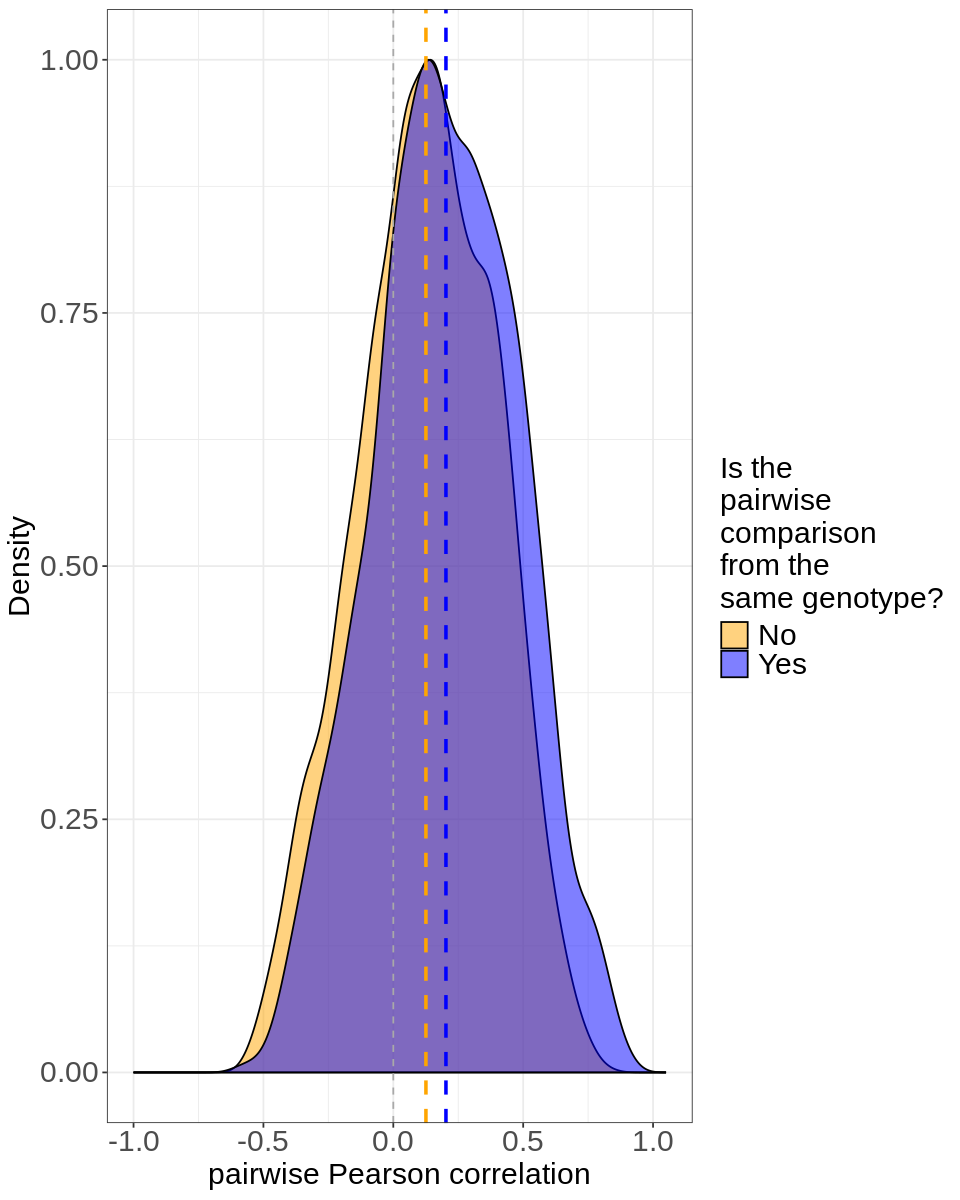

In [8]:
# Calculate mean correlations for each group
mean_values <- corr_results_df %>%
  group_by(same_genotype) %>%
  summarize(mean_correlation = mean(correlation))

focus_corr_colors = c(
    "TRUE" = "blue",
    "FALSE" = "orange"
)
focus_corr_labels  = c(
    "TRUE" = "Yes",
    "FALSE" = "No"
)

# Create the plot
genotype_corr_gg <- (
  ggplot(corr_results_df, aes(x = correlation, fill = same_genotype))
  + stat_density(aes(y = after_stat(scaled)), geom = "density", alpha = 0.5, position = "identity")
  + scale_fill_manual(
      "Is the\npairwise\ncomparison\nfrom the\nsame genotype?",
      values = focus_corr_colors,
      labels = focus_corr_labels
  )
  + guides(
      color = guide_legend(
          override.aes = list(size = 2)
      )
  )
  + labs(x = "pairwise Pearson correlation", y = "Density")
  + geom_vline(xintercept = 0, linetype = "dashed", color = "darkgrey")
  + geom_vline(data = mean_values, aes(xintercept = mean_correlation, color = same_genotype), 
               linetype = "dashed", linewidth = 1, show.legend = FALSE)
  + scale_color_manual(values = focus_corr_colors)  # Use the same colors as the fill
  + xlim(-1, 1.05)
  + theme_bw()
  + theme(
      # x and y axis text size
      axis.text.x = element_text(size = 18),
      axis.text.y = element_text(size = 18),
      # x and y axis title size
      axis.title.x = element_text(size = 18),
      axis.title.y = element_text(size = 18),
      # legend text size
      legend.text = element_text(size = 18),
      legend.title = element_text(size = 18),
  )
)

genotype_corr_gg


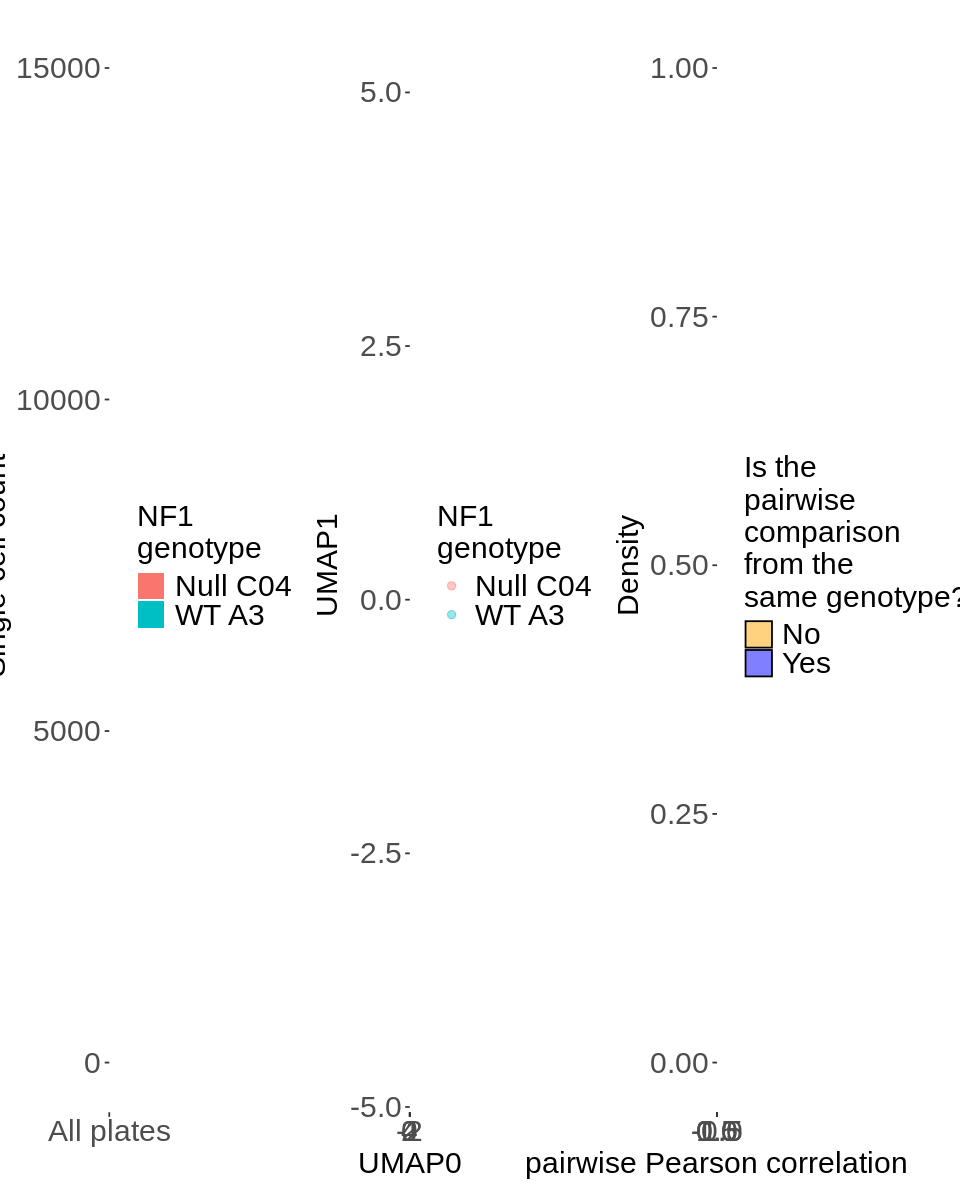

In [9]:
align_plot <- (
    histogram_plot |
    umap_fig_gg |
    genotype_corr_gg
) + plot_layout(widths= c(2,2,2))

align_plot

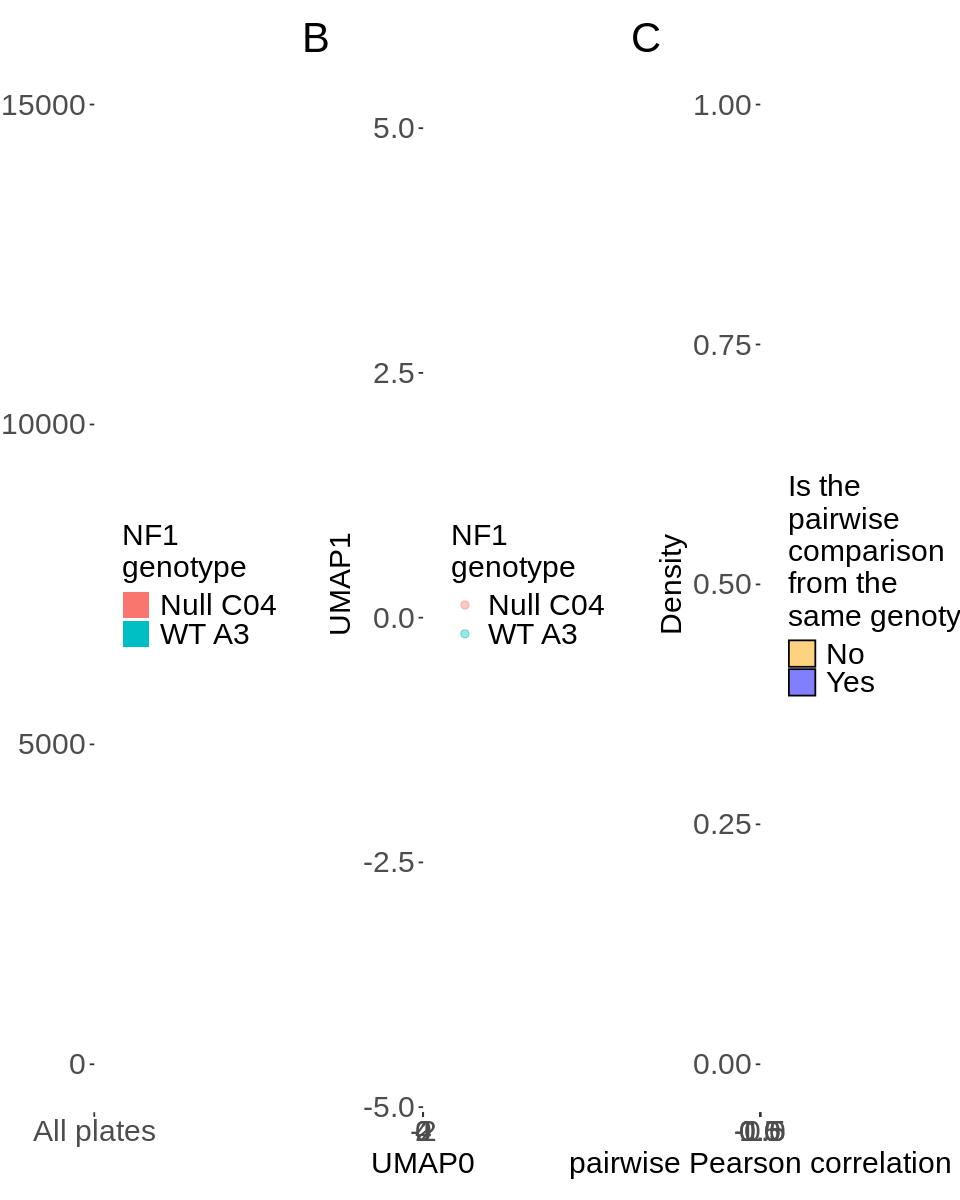

In [10]:
fig_2_gg <- (
  align_plot
) + plot_annotation(tag_levels = "A") & theme(plot.tag = element_text(size = 25))

# Save or display the plot
ggsave(output_main_figure_2, plot = fig_2_gg, dpi = 500, height = 6, width = 18)

fig_2_gg